In [2]:
import Control.Applicative

partitionM :: Applicative m => (a -> m Bool) -> [a] -> m ([a],[a])
partitionM p = foldr f (pure ([],[])) where
  f x = liftA2 ifStmt (p x) where
    ifStmt flg (tr,fl)
      | flg = (x:tr,fl)
      | otherwise = (tr,x:fl)
      
quickSortM :: Monad m => (a -> a -> m Bool) -> [a] -> m [a]
quickSortM p [] = pure []
quickSortM p (x:xs) = do
  (gt,le) <- partitionM (p x) xs
  ls <- quickSortM p le
  gs <- quickSortM p gt
  pure (ls ++ [x] ++ gs)

:ext DeriveFunctor

data DecTree t a
  = Pure a
  | Choice t (DecTree t a) (DecTree t a)
  deriving Functor

instance Applicative (DecTree t) where
  pure = Pure
  Pure f <*> xs = fmap f xs
  Choice c ls rs <*> xs = Choice c (ls <*> xs) (rs <*> xs)
  
instance Monad (DecTree t) where
  Pure x >>= f = f x
  Choice c ls rs >>= f = Choice c (ls >>= f) (rs >>= f)

data Comparison a = a :<= a deriving Show

traceCompare :: a -> a -> DecTree (Comparison a) Bool
traceCompare x y = Choice (x :<= y) (Pure True) (Pure False)

:ext FlexibleContexts

import           IHaskell.Display          (IHaskellDisplay (display))
import           IHaskell.Display.Diagrams (diagram)
import           Diagrams.Backend.Cairo    (Cairo)
import           Diagrams.Prelude          (Diagram, bg, centerXY, circle,
                                            dashingG, fc, fontSizeL, lc,
                                            opacity, pad, text, white, ( # ),
                                            (~~), (<>))
import           Diagrams.TwoD.Layout.Tree (renderTree', symmLayout)
import qualified Data.Tree                 as Rose

instance (Show a, Show b) => IHaskellDisplay (DecTree a b) where
    display = display . diagram . drawTree . toTree
      where
        toTree (Pure x)
            = Rose.Node (False,show x) []
        toTree (Choice i l r)
            = Rose.Node (True,show i) [toTree l, toTree r]
        renderNode n = text n # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white
        renderBranch (_,l) (vr,r)
          | fst vr = l ~~ r
          | otherwise = l ~~ r
                      # dashingG [0.05, 0.05] 0
        drawTree
            = pad 1.1
            . centerXY
            . renderTree' (renderNode . snd) renderBranch
            . symmLayout

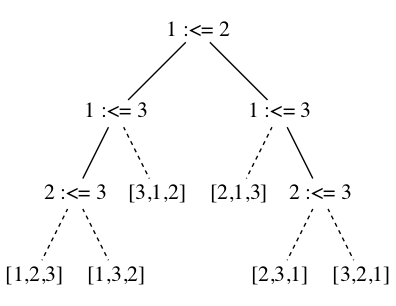

In [3]:
:opt svg

quickSortM traceCompare [1,2,3]

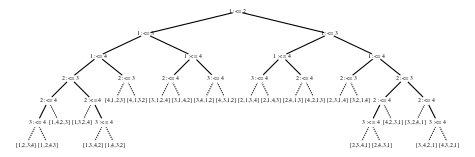

In [5]:
quickSortM traceCompare [1,2,3,4]